# AFARINICK COMPANY LIMITED TIME SERIES FORECASTING

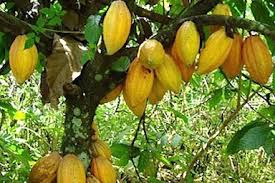, 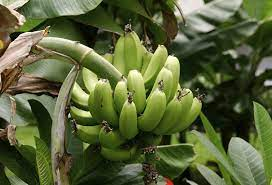




## INTRODUCTION

Afarinick Company Limited (ACL) is a subsidiary of CJ Commodities Limited and a sister company of AMP Logistics (GH) Limited borne out of the need to contribute to the agricultural sector through the provision of an all-inclusive supply chain management service ranging from farm management services, marketing of produce, input, and quality planting material supply.

### GOAL OF THE PROJECT

Forecast the number of **achievements per activies per Month** for AFarinick Company Limited

### LIBRARIES

In [1]:
# Data handling
import pandas as pd
import numpy as np
#from calendar import *

# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
from pandas import Series

# Time series models
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

# Feature Processing (Scikit-learn processing, etc. )
import sklearn 
import scipy
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Evalution Metrics
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GroupKFold, RepeatedKFold, KFold
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

# Other packages
import pickle
import os
import joblib
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis and Data Preprocessing

In [2]:
data = pd.read_csv('Afarinick.csv')

In [56]:
# convert to date time 
data['date'] = pd.to_datetime(dict(year=data.year, month=data.month, day=data.days))

In [4]:
data.head()

,DISTRICT,ACTIVITY,FARM SERVICE,month,year,days,ACHIEVEMENT,date
0,ADABOKROM,ABORICIDE APPLICATION,TREATMENT,1,2023,28,18.330000,2023-01-28
1,ADABOKROM,ABORICIDE APPLICATION,TREATMENT,2,2023,28,93.050000,2023-02-28
2,ADABOKROM,ABORICIDE APPLICATION,TREATMENT,3,2023,7,67.160000,2023-03-07
3,ADABOKROM,ABORICIDE APPLICATION,TREATMENT,3,2023,14,57.654032,2023-03-14
4,ADABOKROM,ABORICIDE APPLICATION,TREATMENT,3,2023,21,92.497979,2023-03-21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DISTRICT      2097 non-null   object        
 1   ACTIVITY      2097 non-null   object        
 2   FARM SERVICE  2097 non-null   object        
 3   month         2097 non-null   int64         
 4   year          2097 non-null   int64         
 5   days          2097 non-null   int64         
 6   ACHIEVEMENT   2097 non-null   float64       
 7   date          2097 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 131.2+ KB


In [6]:
data.duplicated().sum()

0

In [7]:
# convert column to 2 decinal
data['ACHIEVEMENT'] = data['ACHIEVEMENT'].apply(lambda x: round(x, 2))

In [8]:
#set date as index
df = data.set_index("date")

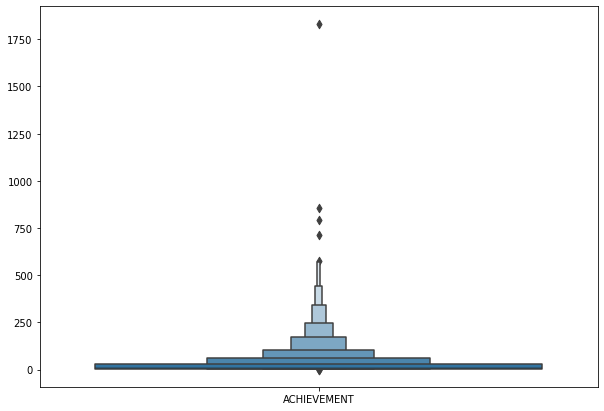

In [9]:
# check for outliers
num_feat = ['ACHIEVEMENT']
fig = plt.figure(figsize =(10, 7))
sns.boxenplot(data=data[num_feat])
plt.show()

In [57]:
#corr = data.corr()
#visualize correlation
#sns.heatmap(corr)

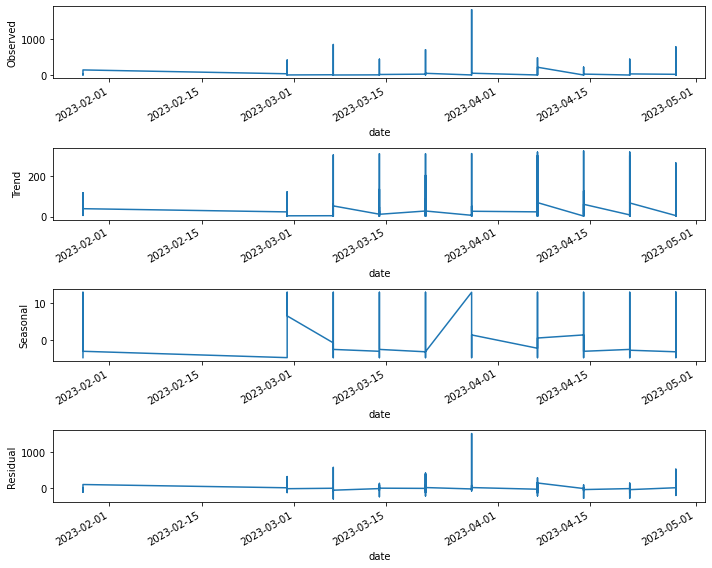

In [11]:
# Perform seasonal decomposition
result = seasonal_decompose(df['ACHIEVEMENT'], model='additive', period=12)  # Adjust the period as needed

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

# Check stationarity using Dickey-Fuller Test

In [12]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [13]:
adf_test(data['ACHIEVEMENT'])

Reject the null hypothesis
Data is stationary


In [14]:
# Perform KPSS test
kpss_result = kpss(data['ACHIEVEMENT'])
kpss_statistic = kpss_result[0]
kpss_pvalue = kpss_result[1]
kpss_critical_values = kpss_result[3]

print("\nKPSS Test:")
print("KPSS Statistic:", kpss_statistic)
print("p-value:", kpss_pvalue)


KPSS Test:
KPSS Statistic: 0.7415671800320107
p-value: 0.01


### rejected the null hypothesis

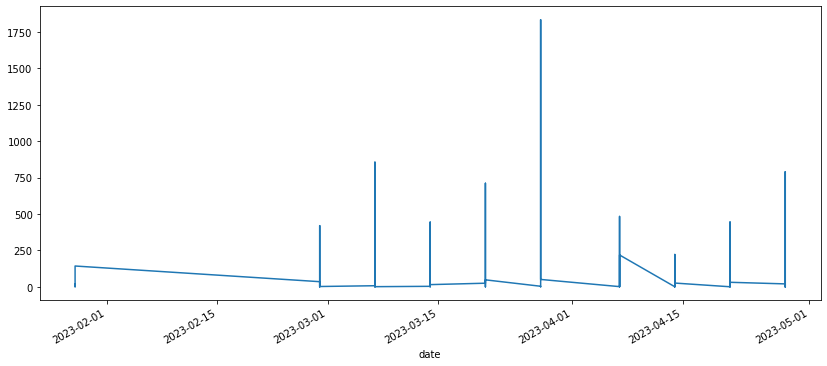

In [15]:
df['ACHIEVEMENT'].plot(figsize=(14,6))
plt.show()

# Feature Engineering

### Encoding

In [16]:
cols = df.select_dtypes(include=['object']).columns
#calling our encoder
encoder = OneHotEncoder(sparse=False)

column_transformer = ColumnTransformer(
    transformers=[('one_hot', encoder, cols)],
    remainder='passthrough'  # To keep non-categorical columns as they are
)

#setting output to DataFrame
Encoded = column_transformer.fit_transform(df[cols])


In [17]:
# Retrieving the feature names after encoding
feature_names = column_transformer.named_transformers_['one_hot'].get_feature_names_out(input_features=cols)
print(feature_names)

['DISTRICT_ADABOKROM' 'DISTRICT_ADJOAFUA' 'DISTRICT_AIYINASE'
 'DISTRICT_AIYINASE ' 'DISTRICT_AJUMAKO' 'DISTRICT_AKONTOMBRA'
 'DISTRICT_ANTOAKROM' 'DISTRICT_ASAMANKESE' 'DISTRICT_ASANKRAGWA'
 'DISTRICT_ASIKUMA' 'DISTRICT_AYIREBI' 'DISTRICT_Asikuma'
 'DISTRICT_Asikuma ' 'DISTRICT_BAWDUA' 'DISTRICT_BEKWAI'
 'DISTRICT_BIBIANI' 'DISTRICT_BOAKO' 'DISTRICT_BODI' 'DISTRICT_BOINSO'
 'DISTRICT_BOINSO ' 'DISTRICT_DABOASE' 'DISTRICT_DADIESO'
 'DISTRICT_DADIESOABA' 'DISTRICT_DIASO' 'DISTRICT_DORMAA'
 'DISTRICT_DUNKWA' 'DISTRICT_ELUBO' 'DISTRICT_ENCHI' 'DISTRICT_ESSAM'
 'DISTRICT_FOSO' 'DISTRICT_GWIRA' 'DISTRICT_HOHOE' 'DISTRICT_HUNI VALLEY'
 'DISTRICT_JASIKAN' 'DISTRICT_JUABOSO' 'DISTRICT_JUASO' 'DISTRICT_JUKWA'
 'DISTRICT_KADE' 'DISTRICT_KEJEBRIL' 'DISTRICT_KONONGO' 'DISTRICT_MAMPONG'
 'DISTRICT_MANKRASO' 'DISTRICT_MANMPONG' 'DISTRICT_MANSO AMENFI'
 'DISTRICT_NANKESE' 'DISTRICT_NKAWIE' 'DISTRICT_NKAWKAW'
 'DISTRICT_NKRANKWANTA' 'DISTRICT_NYAKROM' 'DISTRICT_NYINAHIN'
 'DISTRICT_ODA' 'DISTRICT_OFFI

In [18]:
Encoded_df= pd.DataFrame(Encoded, columns =feature_names,index=df.index )

In [19]:
# Drop the original  column from the original DataFrame
df_t = df.drop(columns=cols,axis = 1)


In [20]:
# Concatenate the one-hot encoded DataFrame to the original DataFrame
train = pd.concat([df_t, Encoded_df], axis=1)


In [22]:
train.head()

,month,year,days,ACHIEVEMENT,DISTRICT_ADABOKROM,DISTRICT_ADJOAFUA,DISTRICT_AIYINASE,DISTRICT_AIYINASE,DISTRICT_AJUMAKO,DISTRICT_AKONTOMBRA,...,ACTIVITY_aboricide application,ACTIVITY_hacking,ACTIVITY_mAINTENANCE WEEDING,ACTIVITY_pRE-WEEDING,ACTIVITY_pre-weeding,ACTIVITY_tree Cutting,ACTIVITY_tree cutting,FARM SERVICE_ESTABLISHMENT,FARM SERVICE_MAINTENANCE,FARM SERVICE_TREATMENT
date,,,,,,,,,,,,,,,,,,,,,
2023-01-28,1,2023,28,18.33,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-02-28,2,2023,28,93.05,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-03-07,3,2023,7,67.16,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-03-14,3,2023,14,57.65,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-03-21,3,2023,21,92.50,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [23]:
# The days column was drop
col = ['days']
df_train = train.drop(columns=col, axis=1)

In [24]:
df_train.head()

,month,year,ACHIEVEMENT,DISTRICT_ADABOKROM,DISTRICT_ADJOAFUA,DISTRICT_AIYINASE,DISTRICT_AIYINASE,DISTRICT_AJUMAKO,DISTRICT_AKONTOMBRA,DISTRICT_ANTOAKROM,...,ACTIVITY_aboricide application,ACTIVITY_hacking,ACTIVITY_mAINTENANCE WEEDING,ACTIVITY_pRE-WEEDING,ACTIVITY_pre-weeding,ACTIVITY_tree Cutting,ACTIVITY_tree cutting,FARM SERVICE_ESTABLISHMENT,FARM SERVICE_MAINTENANCE,FARM SERVICE_TREATMENT
date,,,,,,,,,,,,,,,,,,,,,
2023-01-28,1,2023,18.33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-02-28,2,2023,93.05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-03-07,3,2023,67.16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-03-14,3,2023,57.65,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-03-21,3,2023,92.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2097 entries, 2023-01-28 to 2023-04-28
Columns: 107 entries, month to FARM SERVICE_TREATMENT
dtypes: float64(105), int64(2)
memory usage: 1.7 MB


In [26]:
# machine learning dependent and independent f
X = df_train.drop(['ACHIEVEMENT'],axis = 1)
y = df_train['ACHIEVEMENT']

# Model Building

### 1. RandomforestClassifier

In [27]:

# Define the number of folds for cross-validation
n_splits = 5

# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize an empty list to store the RMSE values
rmse_scores = []

# Initialize an empty list to store the trained models
trained_models = []

# Iterate over the splits
for fold_index, (train_index, test_index) in enumerate(tscv.split(X)):
    # Split the data into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize the model
    model = RandomForestRegressor()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Save the RMSE score
    rmse_scores.append(rmse)
    
    # Save the trained model
    trained_models.append(model)
    
    
# Create a DataFrame with fold index and corresponding RMSE scores
result_df = pd.DataFrame({'Fold': range(n_splits), 'RMSE': rmse_scores})

In [28]:
result_df.head()

,Fold,RMSE
0,0,70.654548
1,1,45.207803
2,2,43.952641
3,3,23.601610
4,4,85.934574


### 2. DecisionTreeClassifier

In [29]:

# Define the number of folds for cross-validation
n_splits = 5

# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize an empty list to store the RMSE values
rmse_scores = []

# Initialize an empty list to store the trained models
trained_models = []

# Iterate over the splits
for fold_index, (train_index, test_index) in enumerate(tscv.split(X)):
    # Split the data into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize the model
    tree = DecisionTreeRegressor()
    
    # Train the model
    tree.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Save the RMSE score
    rmse_scores.append(rmse)
    
    # Save the trained model
    trained_models.append(model)
    
    # Save the model using pickle
    with open(f"model_fold_{fold_index}.pickle", "wb") as file:
        pickle.dump(model, file)

   

In [30]:
# Create a DataFrame with fold index and corresponding RMSE scores
result = pd.DataFrame({'Fold': range(n_splits), 'RMSE': rmse_scores})
result

,Fold,RMSE
0,0,29.424388
1,1,19.425459
2,2,16.518415
3,3,15.904719
4,4,85.934574


In [31]:
# Save the encoder using pickle
joblib.dump(column_transformer, 'encoder.pkl')

['encoder.pkl']

# Time Series Model

# AR

In [51]:
x=df_train['ACHIEVEMENT']
X_train, X_test = x[:900], x[:111]
print(len(X_train), len(X_test))

900 111


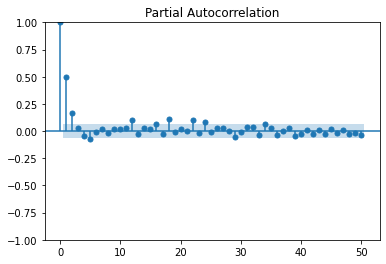

In [47]:
pacf = plot_pacf(X_train,lags = 50)

In [48]:
armodel = AutoReg(X_train, lags = 50).fit()

In [49]:
pred = armodel.predict(
    start=len(X_train),
    end=len(x)-1,
    dynamic=False
)
pred

900     21.685747
901     17.783820
902     18.870702
903     19.684523
904     26.003433
          ...    
2092    36.073765
2093    36.073765
2094    36.073765
2095    36.073765
2096    36.073765
Length: 1197, dtype: float64

# 2.SARIMA

In [54]:
# Fitting the model
model = SARIMAX(X_train, order=(5, 1, 5), seasonal_order=(0,0,0,0)) 
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            ACHIEVEMENT   No. Observations:                  900
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -5191.396
Date:                Fri, 07 Jul 2023   AIC                          10404.791
Time:                        01:39:44   BIC                          10457.605
Sample:                             0   HQIC                         10424.967
                                - 900                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7413      0.480     -1.544      0.122      -1.682       0.199
ar.L2         -0.2478      0.532     -0.466      0.641      -1.290       0.794
ar.L3          0.1409      0.301      0.468      0.640      -0.450       0.732
ar.L4         -0.0824      0.354     -0.233      0.816      -0.776       0.612
ar.L5          0.2114      0.149      1.417      0.156      -0.081       0.504
ma.L1          0.1507      0.481      0.314      0.754      -0.792       1.093
ma.L2         -0.2656      0.316     -0.840      0.401      -0.886       0.354
ma.L3         -0.4179      0.343     -1.220      0.223      -1.089       0.254
ma.L4          0.0033      0.499      0.007      0.995      -0.975       0.982
ma.L5         -0.4501      0.181     -2.488      0.013      -0.805      -0.096
sigma2      6275.7337     61.662    101.777      0.000    6154.879    6396.589
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            806511.31
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             7.70
Prob(H) (two-sided):                  0.00   Kurtosis:                       148.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
# Make predictions on the test data
SARIMA_pred = model_fit.predict(
    start=len(X_train),
    end=len(x)-1,
    typ="levels")
SARIMA_pred

900     17.178712
901     17.215679
902     18.142332
903     20.447545
904     24.264355
          ...    
2092    24.195771
2093    24.195771
2094    24.195771
2095    24.195771
2096    24.195771
Name: predicted_mean, Length: 1197, dtype: float64

# Hyperparameter Tuning For The Best Model

# Decision Tree

In [ ]:
# Define the decisiontree classifier
#tree = DecisionTreeRegressor()

# Define the parameter grid for hyperparameter tuning
#param_grid = {
    #'max_depth': [3, 5, 7],
    #'learning_rate': [0.1, 0.01, 0.001],
    #'n_estimators': [100, 200, 300],
    #'min_child_weight': [1, 3, 5]
#}

# Perform grid search cross-validation
#grid_search = GridSearchCV(xgb_model, param_grid, cv=5)
#grid_search.fit(X_train, y_train)

# Get the best hyperparameters
#best_params = grid_search.best_params_
#print("Best Hyperparameters:", best_params)

# Train a new model with the best hyperparameters
#best_model = xgb.XGBClassifier(**best_params)
#best_model.fit(X_train, y_train)

# Make predictions on the test set
#y_pred = best_model.predict(X_test)

# Evaluate the model
#mse = mean_squared_error(y_test, y_pred )
#rmse = np.sqrt(mean_squared_error(y_test, y_pred )).round(2)

#results = pd.DataFrame([['XGBOOST', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
#results